In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os.path

import scipy,scipy.spatial
import matplotlib
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/ucsd-cse-251b-class-competition.zip ./drive/MyDrive/CSE251B/

In [ ]:
drive.flush_and_unmount()

In [ ]:
!cp ./weights.w ./drive/MyDrive/CSE251B/

In [ ]:
!cp ./drive/MyDrive/CSE\ 251B/ucsd-cse-251b-class-competition.zip ./
!unzip ucsd-cse-251b-class-competition.zip

In [ ]:
!cp ./drive/MyDrive/CSE\ 251B/weights_CNN4.w ./

### model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path
import numpy
import pickle
from glob import glob

"""
 This notebook uses train as an example.
 Change to the val folder for evaluation
"""

new_path = "./ucsd-cse-251b-class-competition/train/train"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272
# sequences sampled at 10HZ rate

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()

    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)

        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
data  = ArgoverseDataset(data_path=new_path)



In [ ]:
def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]

    inp = torch.LongTensor(inp).to(device)
    out = torch.LongTensor(out).to(device)
    return [inp, out]

In [ ]:
batch_sz = 128

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    valid_x = []
    valid_y = []
    for scene in batch:

        mask = scene['car_mask']
        inp = numpy.dstack([scene['p_in'], scene['v_in']])
        out = numpy.dstack([scene['p_out'], scene['v_out']])
        #print(out.shape)
        for j in range(len(mask)):
          if mask[j][0]==1:
            valid_x.append(inp[j])
            valid_y.append(out[j])
        '''
        inp = numpy.stack( inp, axis=0 )
        out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
        out = numpy.stack( out, axis=0 )
        '''
    inp = torch.LongTensor(valid_x).to(device)
    out = torch.LongTensor(valid_y).to(device)
    return [inp, out]

#train_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

#split_number = int(len(data)*0.8)
import random
#train_idx = [i for i in range(split_number)]
train_idx = random.sample([i for i in range(0,len(data))],int(0.8*len(data)))
test_idx = list(set([i for i in range(0,len(data))])-set(train_idx))
#test_idx = [i+split_number for i in range(len(data)-split_number)]
train_sub = torch.utils.data.Subset(data, train_idx)
test_sub = torch.utils.data.Subset(data, test_idx)

train_dataset = DataLoader(train_sub,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)
test_dataset = DataLoader(test_sub,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

1288
322


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## v4: 30 frames

In [ ]:
import matplotlib.pyplot as plt
import random

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1_px = nn.Conv1d(1, 16, 5,padding=(0,2),padding_mode='replicate')
        self.conv1_py = nn.Conv1d(1, 16, 5,padding=(0,2),padding_mode='replicate')
        self.conv1_vx = nn.Conv1d(1, 16, 5,padding=(0,2),padding_mode='replicate')
        self.conv1_vy = nn.Conv1d(1, 16, 5,padding=(0,2),padding_mode='replicate')
        '''
        self.conv2_px = nn.Conv1d(16, 32, 5,padding=(0,2),padding_mode='replicate')
        self.conv2_py = nn.Conv1d(16, 32, 5,padding=(0,2),padding_mode='replicate')
        self.conv2_vx = nn.Conv1d(16, 32, 5,padding=(0,2),padding_mode='replicate')
        self.conv2_vy = nn.Conv1d(16, 32, 5,padding=(0,2),padding_mode='replicate')

        self.conv4_px = nn.Conv1d(32, 16, 5,padding=(0,2),padding_mode='replicate')
        self.conv4_py = nn.Conv1d(32, 16, 5,padding=(0,2),padding_mode='replicate')
        self.conv4_vx = nn.Conv1d(32, 16, 5,padding=(0,2),padding_mode='replicate')
        self.conv4_vy = nn.Conv1d(32, 16, 5,padding=(0,2),padding_mode='replicate')
        '''
        self.conv3_px = nn.Conv1d(16, 1, 5,padding=(0,2),padding_mode='replicate')
        self.conv3_py = nn.Conv1d(16, 1, 5,padding=(0,2),padding_mode='replicate')
        self.conv3_vx = nn.Conv1d(16, 1, 5,padding=(0,2),padding_mode='replicate')
        self.conv3_vy = nn.Conv1d(16, 1, 5,padding=(0,2),padding_mode='replicate')


        self.conv1_pxy = nn.Conv1d(2, 16, 5,padding=(0,2),padding_mode='replicate')
        self.conv1_vxy = nn.Conv1d(2, 16, 5,padding=(0,2),padding_mode='replicate')
        self.conv1_pvx = nn.Conv1d(2, 16, 5,padding=(0,2),padding_mode='replicate')
        self.conv1_pvy = nn.Conv1d(2, 16, 5,padding=(0,2),padding_mode='replicate')

        self.conv2_pxy = nn.Conv1d(16, 1, 5,padding=(0,2),padding_mode='replicate')
        self.conv2_vxy = nn.Conv1d(16, 1, 5,padding=(0,2),padding_mode='replicate')
        self.conv2_pvx = nn.Conv1d(16, 1, 5,padding=(0,2),padding_mode='replicate')
        self.conv2_pvy = nn.Conv1d(16, 1, 5,padding=(0,2),padding_mode='replicate')

        #self.activation = nn.Sigmoid()
        self.activation = nn.ReLU()

        #self.avgpool = torch.nn.AvgPool2d((2,1))
        #self.embedding = torch.nn.Embedding(num_embeddings = 65000, embedding_dim = 64)
        #self.lstm = torch.nn.LSTM(input_size = 1, hidden_size = 6*30*4, num_layers = 1,
        #                            batch_first = True, dropout = 0.2)
        #self.decoder = torch.nn.Conv2d(60,60,1)
        #self.decoder2 = torch.nn.AvgPool2d((9,1))
        self.lstm = torch.nn.LSTM(input_size = 8, hidden_size = 512, num_layers = 2, batch_first = True, dropout = 0.2)

        self.dense1 = nn.Linear(512, 256)
        self.dense2 = nn.Linear(256, 120)
        # as we have 5 classes
        #self.linear = nn.Linear(8*2*512, 5) # last dimension
    def forward(self, x):
        px,py,vx,vy=x
        px = self.activation(self.conv1_px(px))
        py = self.activation(self.conv1_py(py))
        vx = self.activation(self.conv1_vx(vx))
        vy = self.activation(self.conv1_vy(vy))
        '''
        px = self.activation(self.conv2_px(px))
        py = self.activation(self.conv2_py(py))
        vx = self.activation(self.conv2_vx(vx))
        vy = self.activation(self.conv2_vy(vy))

        px = self.activation(self.conv4_px(px))
        py = self.activation(self.conv4_py(py))
        vx = self.activation(self.conv4_vx(vx))
        vy = self.activation(self.conv4_vy(vy))
        '''
        px = self.activation(self.conv3_px(px))
        py = self.activation(self.conv3_py(py))
        vx = self.activation(self.conv3_vx(vx))
        vy = self.activation(self.conv3_vy(vy))


        pxy = torch.cat((px,py), 1)
        vxy = torch.cat((vx,vy), 1)


        pvx = torch.cat((px,vx), 1)
        pvy = torch.cat((py,vy), 1)

        pxy = self.activation(self.conv1_pxy(pxy))
        vxy = self.activation(self.conv1_vxy(vxy))
        pvx = self.activation(self.conv1_pvx(pvx))
        pvy = self.activation(self.conv1_pvy(pvy))

        pxy = self.activation(self.conv2_pxy(pxy))
        vxy = self.activation(self.conv2_vxy(vxy))
        pvx = self.activation(self.conv2_pvx(pvx))
        pvy = self.activation(self.conv2_pvy(pvy))

        x = torch.cat((px,py,vx,vy,pxy,vxy,pvx,pvy), 1)
        x = torch.permute(x,(0,2,1))

        x,_ = self.lstm(x)
        # return-sequence = false
        x = x[:, -1, :]

        #x = torch.flatten(x,1)
        #x = self.conv2(x)
        #x = self.activation(self.dense1(x))
        x = self.dense1(x)
        x = self.dense2(x)
        x = x.reshape((x.size()[0],30,4))

        return x

# create our model

lstm = CNNClassifier()
lstm.to(device)

CNNClassifier(
  (conv1_px): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_py): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_vx): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_vy): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv3_px): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv3_py): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv3_vx): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv3_vy): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_pxy): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_vxy): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=repl

In [ ]:
num_epochs = 200
learning_rate = 0.001

#input_size = 4
#hidden_size = 2
num_layers = 2

num_classes = 1

#lstm = nn.LSTM(input_size=(19,4), hidden_size=128, num_layers=2, proj_size=(30,4))

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
#optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
train_loss_overall = []
val_loss_overall = []
global_min = 99999999
# Train the model
for epoch in range(num_epochs):
    for i_batch, sample_batch in enumerate(train_dataset):
        trainX, trainY = sample_batch


        #trainX = torch.reshape(trainX,(trainX.shape[0]*trainX.shape[1], trainX.shape[2], trainX.shape[3]))
        trainX = trainX.float()

        #trainY = torch.reshape(trainY,(trainY.shape[0]*trainY.shape[1], trainY.shape[2], trainY.shape[3]))
        trainY = trainY.float()

        xy = trainX[:,:,0:2]

        start = xy[:,0:1,:]
        start_repeat = start.repeat((1,19,1))
        # align xy to 0,0 start
        xy = xy-start_repeat
        #rotate so the final orientation is pointing towards positive x axis
        displacement = xy[:,18:19,:] - xy[:,0:1,:]
        # tan = oppo/adj
        angle = torch.atan2(displacement[:,:,1],displacement[:,:,0])
        #angle = torch.squeeze(angle)


        rotation_matrix = torch.cat((torch.hstack((torch.cos(angle),-torch.sin(angle)))[:,:,None],torch.hstack((torch.sin(angle),torch.cos(angle)))[:,:,None]),dim=2)

        translated = torch.matmul(xy,rotation_matrix)
        #print(translated.shape)




        # preprocess data
        px = translated[:,:,0]
        px = px[:,None,:]

        py = translated[:,:,1]
        py = py[:,None,:]

        vx = trainX[:,:,2]
        vx = vx[:,None,:]

        vy = trainX[:,:,3]
        vy = vy[:,None,:]

        #print(px.shape)
        outputs = lstm([px,py,vx,vy])
        optimizer.zero_grad()


        #print(trainY.shape)
        #print(trainY[:,:,0:1,:].shape)
        # obtain the loss function
        #mean_recover = torch.stack((mean_px[:,0],mean_py[:,0],mean_vx[:,0],mean_vy[:,0]))
        #std_recover = torch.stack((std_px[:,0],std_py[:,0],std_vx[:,0],std_vy[:,0]))

        #print(std_recover.shape)
        #print(outputs.shape)
        #outputs = torch.mul(outputs,std_recover.T) + mean_recover.T


        outputs_xy = outputs[:,:,:2]
        outputs_recover = torch.matmul(outputs_xy,-1.0*rotation_matrix)+start.repeat((1,30,1))

        #outputs = torch.hstack((torch.squeeze(outputs_recover),outputs[:,2:4]))


        #print(trainY.shape)
        #loss = criterion(outputs, trainY[:,0,:])
        loss = criterion(torch.squeeze(outputs_recover), trainY[:,:,:2])

        loss.backward()

        optimizer.step()
        if i_batch %1000==0:
            print(i_batch)
    if epoch % 1 == 0:
      print("Epoch: %d, training loss: %1.5f" % (epoch, loss.item()))
      total=0
      with torch.no_grad():
          mean_squared_error = nn.MSELoss().to(device)
          for i_batch, sample_batch in enumerate(test_dataset):
              testX, testY = sample_batch
              testX = testX.float().to(device)
              #print(testX.is_cuda)
              testY = testY.float().to(device)
              # preprocess data
              xy = testX[:,:,0:2]

              start = xy[:,0:1,:]
              start_repeat = start.repeat((1,19,1))
              # align xy to 0,0 start
              xy = xy-start_repeat
              #rotate so the final orientation is pointing towards positive x axis
              displacement = xy[:,18:19,:] - xy[:,0:1,:]
              # tan = oppo/adj
              angle = torch.atan2(displacement[:,:,1],displacement[:,:,0])
              #angle = torch.squeeze(angle)


              rotation_matrix = torch.cat((torch.hstack((torch.cos(angle),-torch.sin(angle)))[:,:,None],torch.hstack((torch.sin(angle),torch.cos(angle)))[:,:,None]),dim=2)

              translated = torch.matmul(xy,rotation_matrix)

              px = translated[:,:,0]
              px = px[:,None,:]

              py = translated[:,:,1]
              py = py[:,None,:]

              vx = testX[:,:,2]
              vx = vx[:,None,:]

              vy = testX[:,:,3]
              vy = vy[:,None,:]
              # calculate outputs by running images through the network
              outputs = lstm([px,py,vx,vy])

              #std_recover = torch.stack((std_px[:,0],std_py[:,0],std_vx[:,0],std_vy[:,0]))
              #outputs = torch.mul(outputs,std_recover.T) + mean_recover.T
              outputs_xy = outputs[:,:,:2]
              outputs_recover = torch.matmul(outputs_xy,-1.0*rotation_matrix)+start.repeat((1,30,1))

              #outputs = torch.hstack((torch.squeeze(outputs_recover),outputs[:,2:4]))
              #print(outputs.is_cuda)
              #print(outputs.shape)
              #mse = mean_squared_error(outputs,testY[:,0,:])
              mse = mean_squared_error(outputs_recover,testY[:,:,:2])
              #print(testY[:,:,0:1,:].shape)
              #print(mse)
              total += mse
          print("Epoch: %d, val loss: %1.5f" % (epoch, total/(i_batch+1)))
    train_loss_overall.append(loss.item())
    val_loss_overall.append(total/(i_batch+1))
    if total/(i_batch+1) < global_min:
      global_min = total/(i_batch+1)
      torch.save(lstm.state_dict(), "./weights_CNN4.w")

0
1000
Epoch: 0, training loss: 70.09001
Epoch: 0, val loss: 74.42181
0
1000
Epoch: 1, training loss: 54.52803
Epoch: 1, val loss: 49.19555
0
1000
Epoch: 2, training loss: 33.64244
Epoch: 2, val loss: 32.30909
0
1000
Epoch: 3, training loss: 5.98168
Epoch: 3, val loss: 9.32161
0
1000
Epoch: 4, training loss: 5.79849
Epoch: 4, val loss: 8.73672
0
1000
Epoch: 5, training loss: 2.87450
Epoch: 5, val loss: 6.58233
0
1000
Epoch: 6, training loss: 3.77294
Epoch: 6, val loss: 5.49670
0
1000
Epoch: 7, training loss: 3.97154
Epoch: 7, val loss: 6.05871
0
1000
Epoch: 8, training loss: 2.74613
Epoch: 8, val loss: 6.22543
0
1000
Epoch: 9, training loss: 3.18183
Epoch: 9, val loss: 5.56047
0
1000
Epoch: 10, training loss: 3.03072
Epoch: 10, val loss: 5.65461
0
1000
Epoch: 11, training loss: 2.67165
Epoch: 11, val loss: 5.43748
0
1000
Epoch: 12, training loss: 2.62707
Epoch: 12, val loss: 4.96822
0
1000
Epoch: 13, training loss: 2.68478
Epoch: 13, val loss: 5.03742
0
1000
Epoch: 14, training loss: 2

KeyboardInterrupt: ignored

In [ ]:

PATH = "modelv4.pt"


torch.save({
            'model_state_dict': lstm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

In [ ]:
!cp ./modelv4.pt ./drive/MyDrive/CSE251B/

In [ ]:
'''
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load(PATH)
lstm.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


model.eval()
# - or -
model.train()
'''

In [ ]:
model = CNNClassifier()
model.to(device)
model.load_state_dict(torch.load("./weights_CNN4.w"))
model.eval()

CNNClassifier(
  (conv1_px): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_py): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_vx): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_vy): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv3_px): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv3_py): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv3_vx): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv3_vy): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_pxy): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=replicate)
  (conv1_vxy): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(0, 2), padding_mode=repl

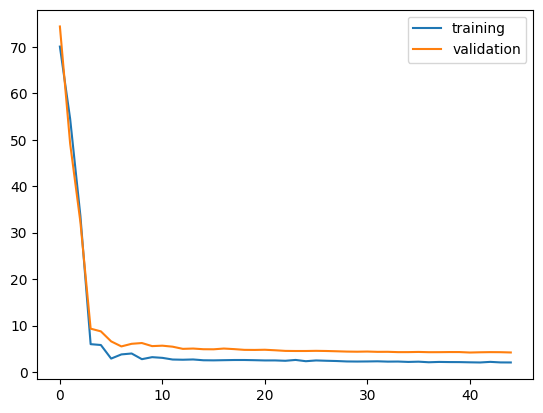

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_overall)
plt.plot([i.detach().cpu().numpy() for i in val_loss_overall])
plt.legend(['training','validation'])
plt.show()

In [ ]:
X = []
y = []
for k in range(10000):
    i = test_sub[k]
    mask = i['car_mask']
    inp = numpy.dstack([i['p_in'], i['v_in']])
    out = numpy.dstack([i['p_out'], i['v_out']])
    #print(out.shape)
    for j in range(len(mask)):
      if mask[j][0]==1:
        X.append(inp[j])
    #X.append(inp)
        y.append(out[j])
    #y.append(out)
    #break

X = np.stack(X,axis=0)
print(X[:8].shape)
y = np.stack(y,axis=0)
print(y[:8].shape)

(8, 19, 4)
(8, 30, 4)


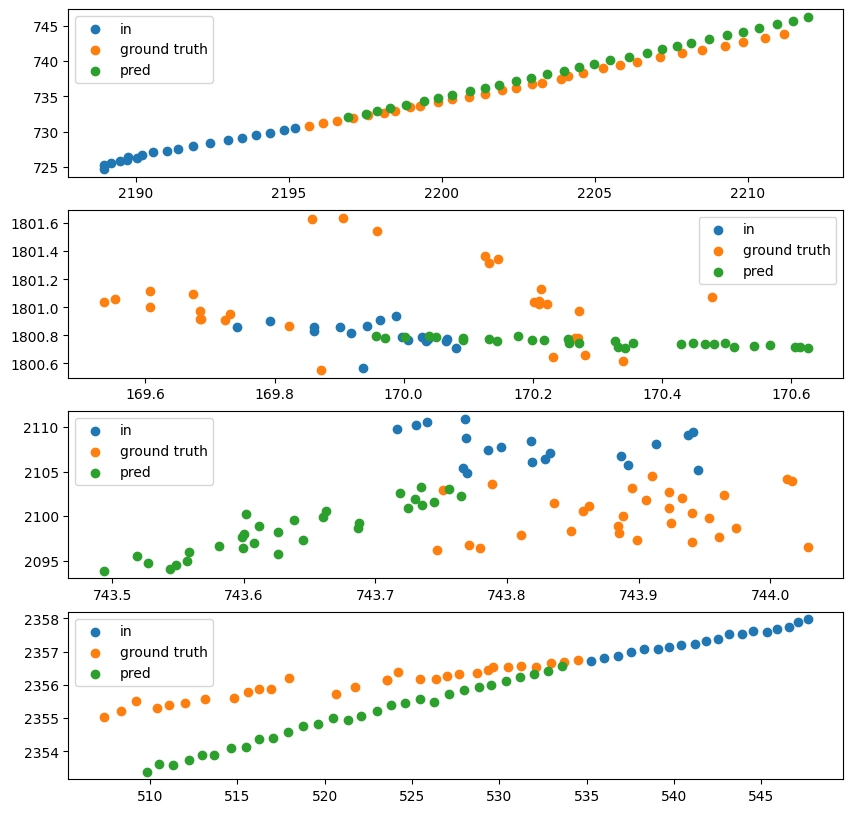

In [ ]:
#agent_id=1
def plot_prediction(ax, inp, out, pred):
    """visualize the trajectory for a batch of samples with a random agent"""
    #inp, out = sample_batch
    #batch_sz = inp.size(0)
    #agent_sz = inp.size(1)
    ax.scatter(inp[:,:,0], inp[:,:,1], label='in')
    ax.scatter(out[:,:,0], out[:,:,1], label='ground truth')
    ax.scatter(pred[:,:,0], pred[:,:,1], label='pred')
    ax.legend()

num_samples = 4

fig, ax = plt.subplots(num_samples, 1, figsize=(10,10))
sample_idx = np.random.permutation(len(test_sub))

for ax_i, s_i in enumerate(sample_idx[:num_samples]):
  inp = X[s_i:s_i+1]
  inp_t = torch.Tensor(inp).to(device)
  out = y[s_i:s_i+1]
  out_t = torch.Tensor(out).to(device)

  xy = X[s_i:s_i+1,:,0:2]

  # align xy to 0,0 start
  start = xy[:1,0:1,:]
  xy_t = torch.Tensor(xy-start).to(device)

  #rotate so the final orientation is pointing towards positive x axis
  displacement = xy_t[:,18:19,:] - xy_t[:,0:1,:]
  # tan = oppo/adj
  angle = torch.atan2(displacement[:,:,1],displacement[:,:,0]).to(device)

  rotation_matrix = torch.cat((torch.hstack((torch.cos(angle),-torch.sin(angle)))[:,:,None],torch.hstack((torch.sin(angle),torch.cos(angle)))[:,:,None]),dim=2).to(device)

  translated = torch.matmul(xy_t,rotation_matrix).to(device)

  # preprocess data
  px = translated[:,:,0]
  px = px[:,None,:]

  py = translated[:,:,1]
  py = py[:,None,:]

  vx = inp_t[:,:,2]
  vx = vx[:,None,:]

  vy = inp_t[:,:,3]
  vy = vy[:,None,:]

  # # preprocess data
  # px = X[:8,:,0]
  # px = px[:,None,:]

  # py = X[:8,:,1]
  # py = py[:,None,:]

  # vx = X[:8,:,2]
  # vx = vx[:,None,:]

  # vy = X[:8,:,3]
  # vy = vy[:,None,:]

  #testX = my_collate_test([data_test[i]])
  #id = np.where(data_test[i]['track_id']==data_test[i]['agent_id'])[0][0]
  #data_to_csv = []
  # for j in range(30):
  #testX = testX.float().to(device)
  #print(testX.shape)
    #print(all_data.shape)
  pred = model([px, py, vx, vy])

  pred_xy = pred[:,:,:2]
  pred_recover = torch.matmul(pred_xy,-1.0*rotation_matrix).cpu().detach().numpy()+start

  # all_data[:,:,:,19:] = outputs
  # pred = all_data[:,19:,:].detach().cpu().numpy()
  """TODO:
    Deep learning model
    training routine
  """
  #print(sample_batch[0].shape)
  plot_prediction(ax[ax_i], inp, out, pred_recover)

plt.show()


In [ ]:
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

3334208


## prediction

In [ ]:
data_test  = ArgoverseDataset(data_path='val_in/val_in')


In [ ]:
np.where(data_test[0]['track_id']==data_test[0]['agent_id'])[0][0]

3

In [ ]:
def my_collate_test(scene):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = numpy.dstack([scene['p_in'], scene['v_in']])
    #out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]

    inp = torch.LongTensor(inp).to(device)
    #out = torch.LongTensor(out).to(device)
    return inp

In [ ]:
import csv
import copy

## v4 out

In [ ]:

f1 = open('./sample_submission.csv', newline='')
f = open('./sample_submission1.csv', 'w')
reader = csv.reader(f1)
writer = csv.writer(f)
row1 = next(reader)  # gets the first line
writer.writerow(row1)
f1.close()




with torch.no_grad():
  for i in range(len(data_test)):
    all_data = torch.zeros([60,19+30,4],dtype=torch.float).to(device)
    all_data[:,:19,:] = my_collate_test(data_test[i])
    assert all_data.shape == (60,19+30,4)
    #testX = my_collate_test([data_test[i]])
    id = np.where(data_test[i]['track_id']==data_test[i]['agent_id'])[0][0]
    all_data = all_data[id:id+1]
    assert all_data.shape == (1,19+30,4)
    data_to_csv = []
    #for j in range(30):
    #testX = testX.float().to(device)
    #print(testX.shape)

    testX = all_data[0:1,0:19,:]
    #print(testX.is_cuda)
    testY = testY.float().to(device)
    # preprocess data
    xy = testX[:,:,0:2]

    start = xy[:,0:1,:]
    start_repeat = start.repeat((1,19,1))
    # align xy to 0,0 start
    xy = xy-start_repeat
    #rotate so the final orientation is pointing towards positive x axis
    displacement = xy[:,18:19,:] - xy[:,0:1,:]
    # tan = oppo/adj
    angle = torch.atan2(displacement[:,:,1],displacement[:,:,0])
    #angle = torch.squeeze(angle)


    rotation_matrix = torch.cat((torch.hstack((torch.cos(angle),-torch.sin(angle)))[:,:,None],torch.hstack((torch.sin(angle),torch.cos(angle)))[:,:,None]),dim=2)

    translated = torch.matmul(xy,rotation_matrix)

    px = translated[:,:,0]
    px = px[:,None,:]

    py = translated[:,:,1]
    py = py[:,None,:]

    vx = testX[:,:,2]
    vx = vx[:,None,:]

    vy = testX[:,:,3]
    vy = vy[:,None,:]
    # calculate outputs by running images through the network
    outputs = lstm([px,py,vx,vy])
    outputs_xy = outputs[:,:,:2]
    outputs_recover = torch.matmul(outputs_xy,-1.0*rotation_matrix)+start.repeat((1,30,1))

        #outputs = torch.hstack((torch.squeeze(outputs_recover)[None,:],outputs[:,2:4]))
      #print(outputs.shape)
      #all_data[0,j+19:j+20,:]=outputs[0,:]
      #outputs = torch.squeeze(outputs[0,:2])
      #print(outputs.shape)
    for j in range(30):
      data_to_csv.append(float(outputs_recover[0,j,0].cpu().numpy()))
      data_to_csv.append(float(outputs_recover[0,j,1].cpu().numpy()))
      #break
      #print(outputs.shape)
    #row = [data_test[i]['scene_idx']]+[(float(outputs[i,0].cpu().numpy()),float(outputs[i,1].cpu().numpy())) for i in range(len(outputs))]
    # open the file in the write mode
    # write a row to the csv file
    assert len(data_to_csv)==60
    row = [data_test[i]['scene_idx']]+data_to_csv
    writer.writerow(row)
    #break
# close the file
f.close()

## saving

In [ ]:
!cp ./weights_CNN4.w ./drive/MyDrive/CSE251B/

In [ ]:
!mv ./weights_CNN.w ./weights_CNNv2.w
!cp ./weights_CNNv2.w ./drive/MyDrive/CSE251B/

In [ ]:
! cp ./sample_submission1.csv ./drive/MyDrive/CSE251B/